In [11]:
from preprocessing import Preprocessor
from data_loader import load_json_data
from evaluation import compute_f1_scores, per_tag_f1
from baseline import tf_idf

In [12]:
focus_tags=['math', 'graphs', 'strings', 'number theory', 'trees', 'geometry', 'games', 'probabilities']
data=load_json_data(r"C:\Users\maloc\OneDrive\Documents\Tag Classification\Code-Tag-Classification\data\code_classification_dataset.zip")

In [13]:
preprocessor=Preprocessor(use_code=False)
train_text, dev_text, test_text, train_labels, dev_labels, test_labels=preprocessor.process_data(data,devset=True,test_size=0.3)
model_tf=tf_idf()



=== CHECKING SPLIT BALANCE ===

=== Focus Tags Statistics ===
math            | train: 1012 dev: 194 test: 203
graphs          | train: 385 dev:  81 test:  76
strings         | train: 304 dev:  65 test:  53
number theory   | train: 250 dev:  53 test:  47
trees           | train: 212 dev:  60 test:  52
geometry        | train: 120 dev:  21 test:  25
games           | train:  66 dev:  21 test:  18
probabilities   | train:  65 dev:  16 test:  11

=== Rare Tags in TRAIN (count < 5) ===
⚠️ schedules: only 3 samples

=== Done checking ===

TRAIN SIZE: 3487
DEV SIZE: 747
TEST SIZE: 748


We see great imbalances in classes, need to tune threshold per classes for best results probably

In [10]:
model_tf.fit(train_text,train_labels)

[('math', 0.0),
 ('graphs', 0.0),
 ('strings', 0.25766871165644173),
 ('number theory', 0.2553191489361702),
 ('trees', 0.2957486136783734),
 ('geometry', 0.0),
 ('games', 0.4406779661016949),
 ('probabilities', 0.41360544217687073)]

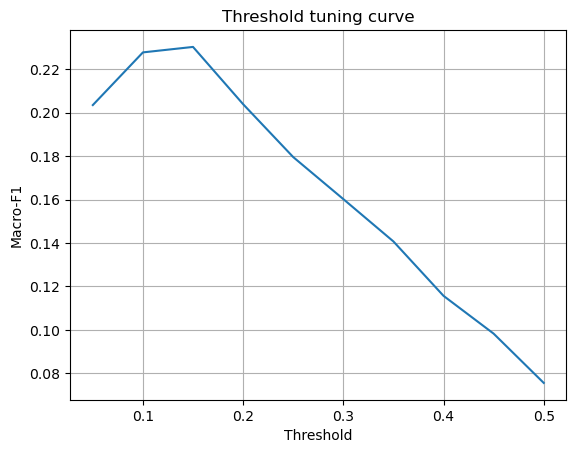

In [11]:
best_thresh,best_f1=model_tf.tune_threshold(dev_text,dev_labels,plot=True,depth=10)

y_pred_binary=model_tf.predict(test_text,threshold=best_thresh)
y_true_binary=model_tf.mlb.transform(test_labels)

per_tag_f1(y_true_binary,y_pred_binary,focus_tags)

[('math', 0.0),
 ('graphs', 0.0),
 ('strings', 0.2531194295900178),
 ('number theory', 0.45901639344262296),
 ('trees', 0.2833530106257379),
 ('geometry', 0.0),
 ('games', 0.46153846153846156),
 ('probabilities', 0.3632286995515695)]

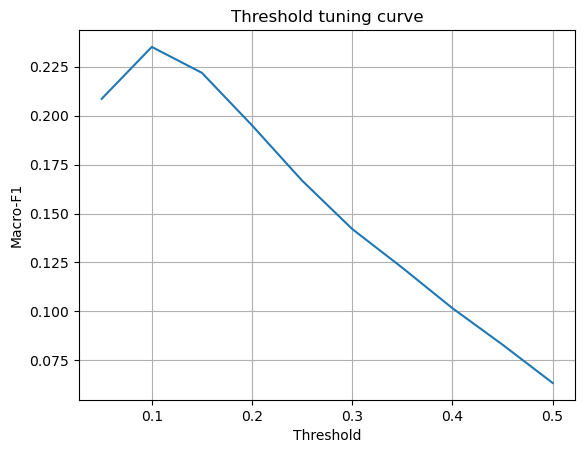

In [6]:
best_thresh,best_f1=model_tf.tune_threshold(dev_text,dev_labels,plot=True,depth=10)

y_pred_binary=model_tf.predict(test_text,threshold=best_thresh)
y_true_binary=model_tf.mlb.transform(test_labels)

per_tag_f1(y_true_binary,y_pred_binary,focus_tags)